In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.modules.transformer as transformer
from tqdm import tqdm
import random


# Define a custom TransformerEncoderLayer
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

    def forward(self, src, src_mask=None):
        src = self.layernorm1(
            src + self.self_attn(src, src, src, attn_mask=src_mask)[0]
        )
        src = self.layernorm2(
            src + self.linear2(self.dropout(F.relu(self.linear1(src))))
        )
        return src


# Define the model
class TransformerClassifier(nn.Module):
    def __init__(self):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(5, 4, padding_idx=4)
        self.position_embedding = nn.Embedding(1500, 4)
        self.encoder = CustomTransformerEncoderLayer(d_model=4, nhead=1)
        self.fc = nn.Linear(4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x) + self.position_embedding(x)
        x = x.transpose(0, 1)
        # attn_mask = (x == 4).transpose(0, 1).unsqueeze(1).repeat(1, x.size(1), x.size(2))
        x = self.encoder(x)
        x = x.transpose(0, 1)
        x = x.mean(dim=1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


# Train the model
model = TransformerClassifier()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
# Load the data
train_data = []
with open("train_dataset.txt", "r") as f:
    for line in tqdm(f):
        x, y = line.strip().split()
        x = torch.tensor([["s", "a", "b", "e", "p"].index(c) for c in x])
        y = torch.tensor(int(y))
        train_data.append((x, y))

test_data = []
with open("test_dataset.txt", "r") as f:
    for line in tqdm(f):
        x, y = line.strip().split()
        x = torch.tensor([["s", "a", "b", "e", "p"].index(c) for c in x])
        y = torch.tensor(int(y))
        test_data.append((x, y))

# Randomly shuffle the data
random.shuffle(train_data)
random.shuffle(test_data)

# Create a tensor for all training data
train_x = []
train_y = []
for x, y in train_data:
    train_x.append(x)
    train_y.append(y)
train_x = torch.stack(train_x)
train_y = torch.tensor(train_y)

# Create a tensor for all test data
test_x = []
test_y = []
for x, y in test_data:
    test_x.append(x)
    test_y.append(y)
test_x = torch.stack(test_x)
test_y = torch.tensor(test_y)

199522it [00:52, 3794.71it/s]
49882it [00:12, 3851.30it/s]


In [62]:
from tqdm import tqdm
from torch import mps
import gc

gc.collect()
mps.empty_cache()
# Put the model and data on mps
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
model = model.to(device)
train_x = train_x.to(device)
train_y = train_y.to(device)

# Train the model
for epoch in range(200):
    # Choose a subset of size 1000
    indices = torch.randperm(len(train_x))[:100]
    train_x_subset = train_x[indices]
    train_y_subset = train_y[indices]

    model.train()
    optimizer.zero_grad()
    output = model(train_x_subset)
    loss = criterion(output, train_y_subset.float().view(-1, 1))
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    # If epoch is a multiple of 10, evaluate the model on the test data
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Pick random 100 samples from the test data
            indices = torch.randperm(len(test_x))[:100]
            test_x_subset = test_x[indices]
            test_y_subset = test_y[indices]
            output = model(test_x_subset)
            # Calculate the accuracy
            correct = (output > 0.5).squeeze(1).float() == test_y_subset.float()
            accuracy = correct.sum() / len(correct)
            print(f"Accuracy: {accuracy.item()}")

Epoch 1, Loss: 0.7407394051551819
Epoch 2, Loss: 0.7683359980583191
Epoch 3, Loss: 0.7939020395278931
Epoch 4, Loss: 0.7380125522613525
Epoch 5, Loss: 0.7315952777862549
Epoch 6, Loss: 0.7455755472183228
Epoch 7, Loss: 0.7627326846122742
Epoch 8, Loss: 0.6863499283790588
Epoch 9, Loss: 0.757702112197876
Epoch 10, Loss: 0.751327633857727


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
# Go 1 by 1 through test data with tqdm and print test accuracy
model.eval()
with torch.no_grad():
    correct = 0
    for x, y in tqdm(zip(test_x, test_y)):
        output = model(x.unsqueeze(0))
        correct += (output > 0.5).squeeze(1).float() == y.float()
    accuracy = correct / len(test_y)
    print(f"Accuracy: {accuracy.item()}")

In [ ]:
# Save the model
torch.save(model.state_dict(), "updated_ab_model.pth")

tensor([[0.9901]], grad_fn=<SigmoidBackward0>)
tensor([1.1038e-05, 2.2358e-03, 2.2358e-03,  ..., 5.4387e-05, 5.4387e-05,
        5.4387e-05], grad_fn=<MeanBackward1>)
tensor([190, 187, 192, 191, 185, 188, 193, 189, 186, 184])
saaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbepppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp

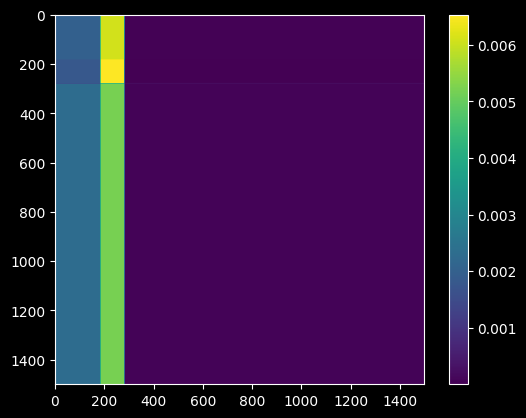

In [136]:
# Load model, pick random sample from training set and print attention weights
model = TransformerClassifier()
model.load_state_dict(
    torch.load("updated_ab_model.pth", map_location=torch.device("cpu"))
)
model.eval()
index = random.randint(0, len(train_x) - 1)
x = train_x[index].unsqueeze(0).to("cpu")
output = model(x)
print(output)
x = model.embedding(x) + model.position_embedding(x)
x = x.transpose(0, 1)
attn_weights = model.encoder.self_attn(x, x, x, attn_mask=None)[1]
print(attn_weights.squeeze(0).mean(dim=0))
# Print indices of top 10 attention weights
print(torch.topk(attn_weights.squeeze(0).mean(dim=0), 10).indices)

# Print the original string
print("".join(["s", "a", "b", "e", "p"][i] for i in train_x[index].tolist()))

# Plot matrix of attention weights
import matplotlib.pyplot as plt

plt.imshow(attn_weights.squeeze(0).detach().numpy())
plt.colorbar()
plt.show()

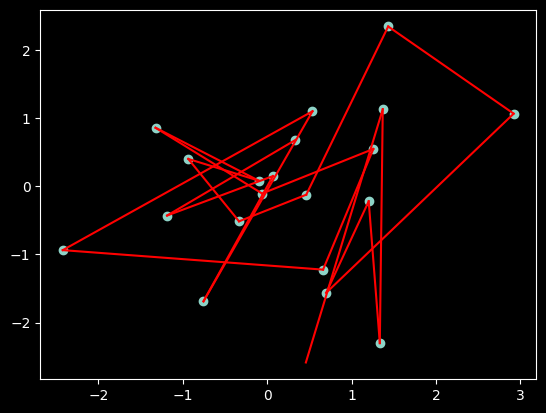

In [150]:
# Do PCA on the position embeddings so they have 2 dimensions isntead of 4
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(model.position_embedding.weight.data.numpy())
position_embedding_pca = pca.transform(model.position_embedding.weight.data.numpy())
# In scatterplot plot just the first 100 position embeddings with line from 0 to 1, 1 to 2, 2 to 3, 3 to 4, etc
n = 20
plt.scatter(position_embedding_pca[:n, 0], position_embedding_pca[:n, 1])
for i in range(n):
    plt.plot(
        position_embedding_pca[i : i + 2, 0], position_embedding_pca[i : i + 2, 1], "r-"
    )
plt.show()